In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from ddgclib._truncated_cone import *
import copy
from ddgclib._plotting import *
from ddgclib._curvatures import *
from timeit import default_timer as timer

In [2]:
def curvature(v):
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij(F, nn)
    HNdA_i = curvature_dict['HNdA_i']
    return HNdA_i

In [3]:
def save_complex(HC,filename):
    '''
    To save the complex, please enter the following line
    #save_complex(HC, 'test_vom_20240209_refinement4.json')
    '''
    for v in HC.V:
        v_new = []
        for i, vi in enumerate(v.x):
            v_new.append(float(vi))

        HC.V.move(v, tuple(v_new))
        v.x_a = np.array(v.x_a, dtype='float')
    HC.save_complex(fn = filename)

In [4]:
def volume(v):
    '''
    require a closed mesh
    '''
    F, nn = vectorise_vnn(v)
    curvature_dict = b_curvatures_hn_ij_c_ij_play(F, nn)
    V_ijk = curvature_dict['V_ijk']
    N_i = curvature_dict['N_i']
    return V_ijk

In [5]:
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t
    avg = sum_num / len(num)
    return avg

In [6]:
def plot_polyscope_plus_normvec(HC):
    # Initialize polyscope
    ps.init()
    ps.set_up_dir("z_up")

    do = coldict['db']
    lo = coldict['lb']
    HC.dim = 2  # The dimension has changed to 2 (boundary surface)
    HC.vertex_face_mesh()
    points = np.array(HC.vertices_fm)
    triangles = np.array(HC.simplices_fm_i)
    ### Register a point cloud
    # `my_points` is a Nx3 numpy array
    my_points = points
    ps_cloud = ps.register_point_cloud("my points", my_points)
    ps_cloud.set_color(tuple(do))
    #ps_cloud.set_color((0.0, 0.0, 0.0))
    verts = my_points
    faces = triangles
    ### Register a mesh
    # `verts` is a Nx3 numpy array of vertex positions
    # `faces` is a Fx3 array of indices, or a nested list
    surface = ps.register_surface_mesh("my mesh", verts, faces,
                             color=do,
                             edge_width=1.0,
                             edge_color=(0.0, 0.0, 0.0),
                             smooth_shade=False)

    # Add normal vectors
    vecs_vert = []
    for v in verts:
        N_f0 = v - np.array([0.0, 0.0, v[2]])
        N_f0 = normalized(N_f0)[0]
        #N_f0_vectors_pairs.append([v.x_a, N_f0])
        vecs_vert.append(N_f0)
    vecs_vert = np.array(vecs_vert) * 1e-4

    #
    '''
        #ps_mesh.add_vector_quantity("rand vecs opt", vecs_vert, radius=1000,
                                length=5000, color=(0.2, 0.5, 0.5))

    # ambient vectors don't get auto-scaled, useful e.g. when representing offsets in 3D space
    ps_mesh.add_vector_quantity("vecs ambient", vecs_vert, vectortype='ambient')
    '''
    #surface.add_vector_quantity("N_f0 vectors", vecs_vert, radius=0.001,
    #                            length=0.005, color=(0.2, 0.5, 0.5))
    surface.add_vector_quantity("N_f0 vectors", vecs_vert, radius=0.07,
                                length=0.1, color=(0.2, 0.5, 0.5))

    surface.add_vector_quantity("N_f0 vectors ambient", vecs_vert, vectortype='ambient')

    ps.show()

In [7]:
def close_boundary(HC, boundary_top, boundary_bottom):
    v_avg_top = np.zeros(3)
    for v in boundary_top:
        v_avg_top += v.x_a

    v_avg_top = v_avg_top/len(boundary_top)
    v_avg_bottom = np.zeros(3)
    for v in boundary_bottom:
        v_avg_bottom += v.x_a

    v_avg_bottom = v_avg_bottom/len(boundary_bottom)

    vat = HC.V[tuple(v_avg_top)]
    for v in boundary_top:
        v.connect(vat)

    vab = HC.V[tuple(v_avg_bottom)]
    for v in boundary_bottom:
        v.connect(vab)
    return HC, boundary_top, boundary_bottom, vat, vab

In [8]:
def b_disc_angle(v, r, bV, print_out=True):
    """
    Takes boundary vertex v and outputs the contact angle

    v: vertex
    N: normal vector estimating the direction of the surface (liquid to gas)
    """

    N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]]) # Version from Stefan
    N_f0 = normalized(N_f0)[0]
    F, nn = vectorise_vnn(v)
    c_outd = b_curvatures_hn_ij_c_ij(F, nn, n_i = N_f0)

    vij = []
    for vn in v.nn:
        if vn in bV:
            continue
        else:
            vij.append(vn)

    if 0:
        for vn in v.nn:
            if vn in bV:
                vij.append(vn)


    E_ij = vij[0].x_a - v.x_a
    E_ik = vij[1].x_a - v.x_a
    E_ij_ik = np.cross(E_ij, E_ik)
    E_ij_ik_norm = np.linalg.norm(E_ij_ik) # || E_ij ^ E_ik ||
    dir_vec = E_ij_ik / E_ij_ik_norm

    if np.dot(N_f0, dir_vec) < 0:
        dir_vec = - dir_vec

    #K_H_i = c_outd['K_H_i']
    HNdA_i = c_outd['HNdA_i']
    C_ij = c_outd['C_ij']
    #HN_i = np.sum(HNdA_i) / np.sum(C_ij)
    n_i = c_outd['n_i']
    HN_i = np.sum(np.dot(HNdA_i, n_i)) / np.sum(C_ij)
    K_H_i = (HN_i/ 2.0)**2


    #TODO: Adjust for other geometric approximations:
    #l_a = 2 * np.pi * r / len(bV)  # arc length
    Xi = 1
    # Gauss-Bonnet: int_M K dA + int_dM kg ds = 2 pi Xi
    # NOTE: Area should be height of spherical cap    # h = R - r * 4np.tan(theta_p)
    # Approximate radius of the great shpere K = (1/R)**2:
    #r =  #TODO: test if this is a good approximation
    R_approx = 1 / np.sqrt(K_H_i)
    theta_p_approx = np.arccos(min([r / R_approx, 1]))
    h = R_approx - r * np.tan(theta_p_approx)
    A_approx = 2 * np.pi * R_approx * h  # Area of spherical cap

    # A_approx  # Approximate area of the spherical cap
    kg_ds = 2 * np.pi * Xi - K_H_i * (A_approx)
    ds = 2 * np.pi * r  # Arc length of whole spherical cap
    k_g = kg_ds / ds  # / 2.0
    phi_est = np.arctan(R_approx * k_g)

    if print_out:
       # print(f'theta_p_approx = {theta_p_approx * 180 / np.pi}')
       # print(f'cos = {[r / R_approx]}')
        print(f'phi_est = {phi_est * 180 / np.pi}')
        print(f'E_ij = {E_ij}')
        print(f'E_ik = {E_ik}')
        print(f'E_ij_ik = {E_ij_ik}')
        print(f'dir_vec = {dir_vec}')
        print(f'np.dot(E_ij_ik_norm, dir_vec) = {np.dot(E_ij_ik_norm, dir_vec)}')
        print(f'E_ij_ik_norm = {E_ij_ik_norm}')
        print(f'vij = {vij}')

    return phi_est, dir_vec, E_ij, E_ik, E_ij_ik# , de # (sum of edge lengths)

In [33]:
def fun_liquid_bridge_N(r_l, r_u, length, refinement, theta_c, tau, gamma, breaking_condition, itermax, contact_angle = True, load_activated = False,itermax_load = 10, save_activated = False,volume_constraint = False, V_init = 1, shearing = False, shearing_parameter = 1):
    '''
    length = length of the inital cone [m]
    tau = size of time step [-]
    d_l = diameter one the lower site of the initial cyliner [m]
    d_u = diameter one the upper site of the initial cyliner [m]
    refinement = number of refinement of the mesh [-]
    theta_c = value of the contact angle in radian [rad]
    gamma = surface_tension [N/m]
    breaking_condition = when this value is reached, the simulation is finished [m]
    itermax = another breaking condition depending on the iteration steps [-]
    contact_angle = is the contact angle actived
    load_activated = with this parameter you have the choice to load a complex instead of creating a new on.
        if load_activated = False: A new mesh will be generated
    itermax_load = number of iteration of the loading complex (necessary paramter for loading the complex function:
    save_activated = with this parameter you have the choice to save the final complex
        if save_activated=False: Nothing happens
        if save_activated=True: The complex will saved under a savename depending on the inital parameters
    '''

    starttime = timer()
    print('Simulation is started!')
    print('-------------------------------------')



    v_l = 0
    v_u = length +v_l

    r_approx = length/2.0  # approximate radius of the contact angle spherical cap
    '''
    -----------------------------------------------------------
    From here, the mesh for an open truncated cone is meshed
    '''
    if load_activated:
        load_filename = 'rl'+str(r_l)+'_ru'+str(r_u)+'_l'+str(length)+'_ref'+str(refinement)+'_contactangle'+str(theta_c)+'_tau'+str(tau)+'_itermax'+str(itermax_load)+'.json'
        HC = Complex(3)
        HC.load_complex(load_filename)
    else:
        HC, bV, K_f, H_f, neck_verts, neck_sols = truncated_cone_initial_N(r_l, r_u, length, refinement,shearing=shearing,shearing_parameter=shearing_parameter)

    # Define bottom boundary condition
    boundary_bottom = []
    N_f0_vectors_pairs = []
    for v in HC.V:
        #if v.x[2] == v_l:
        #if v.x[2] >= v_l - 1e-5 and v.x[2] <= v_l + 1e-5 or v.x[2] == v_l:
        if v.x[2] == v_l:
          #  print(f'v.x bottom ={v.x}')
            boundary_bottom.append(v)
    # Define top boundary condition
    boundary_top = []
    for v in HC.V:
        #if v.x[2] == v_u:
        #if v.x[2] >= v_u - 1e-5 and v.x[2] <= v_u + 1e-5 or v.x[2] == v_u:
        if v.x[2] == v_u:
           # print(f'v.x top ={v.x}')
            boundary_top.append(v)

    # runvariable for the iteration tracking
    residual_iteration = 0

    #HC, boundary_top, boundary_bottom, vat, vab = close_boundary(HC, boundary_top, boundary_bottom)
    iteration_list = []

    # list to track the progress from df
    df_list_max = []
    df_list_min = []

    # list to track the progress of HNdA
    dHNdA_list_min = []
    dHNdA_list_max = []

    res_list = []

    volume_list = []
    contact_angle_list_bottom   = []
    contact_angle_list_top      = []

    '''
    ---------------------------------------------------------------------------------------------------------------------------
    From here, the optimization is started
    '''
    iters = 0
    while True:

        if itermax == 0:
            print('Mesh is generated. Optimization was not carried out because itermax = 0.')
            break

        if iters > itermax:
            endtime = timer()
            print('-------------------------------------')
            print("Too many iterations! Simulation is canceled!")
            print(f"Time elapsed for canceled Simulation: {endtime-starttime:.2f} s")
            break
        '''
        Calculating the volume of the hole mesh in every volume
        '''

        if 1:
            V_current = 0
            number_v = 0
            HC, boundary_top, boundary_bottom, vat, vab = close_boundary(HC, boundary_top, boundary_bottom) # closing the boundary

            for v in HC.V:
                number_v += 1
                V_ijk = volume(v)
                V_current += np.sum(V_ijk)

            V_current = V_current/3
            print(f'V_current = {V_current}')
            volume_list.append(V_current)

            dV = (V_init-V_current)/V_init

            HC.V.remove(vat) # Open the boundary (Important, otherwise the angle-calculation will not work)
            HC.V.remove(vab) # Open the boundary (Important, otherwise the angle-calculation will not work)

        # dummy list to find the maximum df
        df_list_dummy       = []
        dHNdA_list_dummy    = []
        v_boundary_interior = {}

        contact_angle_list_bottom_dummy = []
        contact_angle_list_top_dummy   = []
       # print(f'number of vertexes = {number_v}')
        cHC = copy.copy(HC)

        for v in cHC.V:
            N_f0 = v.x_a - np.array([0.0, 0.0, v.x_a[2]])
            N_f0 = normalized(N_f0)[0]
            N_f0_vectors_pairs.append([v.x_a, N_f0])

            dV_dummy = dV
            # Define bottom boundary condition
            if v in set(boundary_bottom):
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_bottom, print_out=False)
                contact_angle_list_bottom_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)

                dV_dummy = 0

                for vnn in v.nn:
                    if (vnn in boundary_bottom): # or (vnn in boundary_top):
                        continue
                    else:
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) *gamma * dE
                        vnn_factor = F_b * dir_vec
                        #vnn_factor = np.dot(vnn_factor,dir_vec)*dir_vec
                        #vnn_factor = np.dot(F_b,N_f0)*N_f0

                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor
                continue

            # Define top boundary condition
            if v in set(boundary_top):
                phi_est, dir_vec, E_ij, E_ik, E_ij_ik = b_disc_angle(v, r=r_approx, bV=boundary_top, print_out=False)
               # contact_angle_list_top_dummy.append(phi_est)
                dE = np.linalg.norm(E_ij) + np.linalg.norm(E_ij)
                dV_dummy = 0
                for vnn in v.nn:
                    if (vnn in boundary_top): # or (vnn in boundary_bottom)
                        continue
                    else:
                        contact_angle_list_top_dummy.append(phi_est)
                        F_b = (np.cos(phi_est) - np.cos(theta_c)) * gamma * dE
                        vnn_factor = F_b * dir_vec
                        #vnn_factor = np.dot(vnn_factor,dir_vec)*dir_vec
                        #vnn_factor = np.dot(F_b,N_f0)*N_f0
                        try:
                            v_boundary_interior[vnn.x] += vnn_factor
                        except KeyError:
                            v_boundary_interior[vnn.x] = vnn_factor
                continue

            # Compute curvature for each interior vertex
            HNdA_i = curvature(v)

            # Enforce boundary contact angle
            db = np.zeros_like(HNdA_i)

            df = - gamma * HNdA_i  # Add compressive force F_c = N_i * (V_initial - V_total)
            #df = np.dot(df, N_f0)*N_f0
           # print(f'v_boundary_interior = {v_boundary_interior}')
            if v.x in v_boundary_interior.keys() and contact_angle:
                db = v_boundary_interior[v.x]  # normalized(HNdA_i)[0]
                df = np.zeros_like(HNdA_i)
            else:
                pass

            # Step in time
            if iters < 50:
                db = np.zeros_like(HNdA_i)
            else:
                db = db

            if volume_constraint:
                if v in set(boundary_top):
                    dv = np.zeros_like(HNdA_i)

                if v in set(boundary_bottom):
                    dv = np.zeros_like(HNdA_i)
                else:
                    dv = np.dot(dV_dummy, HNdA_i) * HNdA_i


            else:
                dv = np.zeros_like(HNdA_i)

            if contact_angle: # contact angle constraint
                 db = np.dot(db, N_f0)*N_f0
                 #db = db
            else:
                db = np.zeros_like(HNdA_i)

            v_new = v.x_a - tau/2 * df  + tau/2 * db +  tau/2 * dv

            '''
            if contact_angle: # condition if the contact angle is activated
                v_new = v.x_a - tau/2 * df  + tau/2 * db
            else:
                v_new = v.x_a - tau/2 * df
            '''

            #v_new = v.x_a - tau/2 * df
            HC.V.move(v, tuple(v_new))
            df_list_dummy.append(np.linalg.norm(df+db))
            dHNdA_list_dummy.append(np.linalg.norm(HNdA_i))

        #contact_angle_list_bottom_dummy.append(phi_est) theta_p_approx * 180 / np.pi
        contact_angle_list_bottom.append(cal_average(contact_angle_list_bottom_dummy)* 180 / np.pi)
        contact_angle_list_top.append(cal_average(contact_angle_list_top_dummy)* 180 / np.pi)


        # save the maximum and minimum datas for the Residuals
        df_list_max.append(max(df_list_dummy))
        df_list_min.append(min(df_list_dummy))
        # save the numbers of iteration for lately plotting
        iteration_list.append(iters)
        dHNdA_list_max.append(max(dHNdA_list_dummy))
        dHNdA_list_min.append(min(dHNdA_list_dummy))

        print(f'number of iteration ={iters}')
       # print(f'len_boundary_bottom = {len(boundary_bottom)}')
       # print(f'boundary_top = {len(boundary_top)}')


        if iters%100 == 0:
            # print(f"Time elapsed: {complex[6]-complex[5]:.2f} s")
            interimstime = timer()
            print(f"Iteration elapsed: {iters:.0f}")
            print(f"Time elapsed:{interimstime-starttime:.2f} s")
            print(f"Amount of highest displacement: {max(df_list_dummy)*10**6:.2f} mikrometer")


        if max(df_list_dummy) < breaking_condition:
            endtime = timer()
            print('-------------------------------------')
            print("Simulation is finished and is terminated without a problem.")
            print(f"Time elapsed for hole Simulation: {endtime-starttime:.2f} s")
            break

        iters += 1

    if save_activated:
        if load_activated:
            itermax_save = itermax + itermax_load
        else:
            itermax_save = itermax

        save_filename = 'rl'+str(round(r_l*1e3,2))+'mm_ru'+str(round(r_u*1e3,2))+'mm_l'+str(round(length*1e3,))+'mm_ref'+str(refinement)+'_contactangle'+str(theta_c)+'_tau'+str(tau)+'_itermax'+str(itermax_save)+'.json'
        save_complex(HC, save_filename)
        print(f'Complex is saved under the name: {save_filename}.')

    result_dict = {}
    result_dict['HC'] = HC

    result_dict['iteration_list'] = iteration_list
    result_dict['df_list_min'] = df_list_min
    result_dict['df_list_max'] = df_list_max
    result_dict['volume_list'] = volume_list
    result_dict['contact_angle_list_bottom'] = contact_angle_list_bottom
    result_dict['contact_angle_list_top'] = contact_angle_list_top
    result_dict['N_f0_vectors_pairs'] = N_f0_vectors_pairs
    result_dict['dHNdA_list_min'] = dHNdA_list_min
    result_dict['dHNdA_list_max'] = dHNdA_list_max


    return result_dict

In [43]:
contact_angle = False
theta_p = 10  # Three phase contact angle in °

shearing=False
shearing_parameter= 1

save_activated=False

volume_constraint=False
V_soll = 0.05


refinement= 3 # NOTE: 2 is the minimum refinement needed for the complex to be manifold

breaking_condition = 1e-9
tau = 1    # Endtime for calculation
itermax = 1
itermax = 500

itermax_load = 25*1e3 # number of iteration of the loaded complex

'''
from Liam 19939
'''
gamma = 2.45e-3  # N/m, surface tension of di-n-butyl phthalate/liquid paraffin mixture
r_i = 15e-3 # Particle Radian

half_filling_angle = 10 # half filling angle in °
S = 0.1 # dimensionless seperation distance

y_i = np.sin(half_filling_angle * np.pi/180.0) * r_i # calculated radian of the liquid bridge
r_l = y_i
r_u = r_l


h_i = r_i -  (r_i**2 - (y_i)**2)**0.5
length = S * r_i + 2 * h_i
global_contact_angle = (half_filling_angle + theta_p) * np.pi/180.0


dummy_parameter2 = fun_liquid_bridge_N(r_l, r_u, length, refinement, global_contact_angle,tau, gamma, breaking_condition,itermax,contact_angle = contact_angle, save_activated=save_activated, load_activated=False, itermax_load = itermax_load, volume_constraint=volume_constraint, V_init= y_i**2 *np.pi * length * V_soll, shearing=shearing, shearing_parameter= shearing_parameter)


HC = dummy_parameter2['HC']
iteration_list = dummy_parameter2['iteration_list']
df_list_max = dummy_parameter2['df_list_max']
volume_list = dummy_parameter2['volume_list']
contact_angle_list_bottom = dummy_parameter2['contact_angle_list_bottom']
contact_angle_list_top= dummy_parameter2['contact_angle_list_top']

Simulation is started!
-------------------------------------
V_current = 3.854938926279787e-08
number of iteration =0
Iteration elapsed: 0
Time elapsed:0.48 s
Amount of highest displacement: 4.27 mikrometer
V_current = 3.8414374598373637e-08
number of iteration =1
V_current = 3.885625116485071e-08
number of iteration =2
V_current = 3.8563075095943e-08
number of iteration =3
V_current = 3.858436104165818e-08
number of iteration =4
V_current = 3.861240517787898e-08
number of iteration =5
V_current = 3.8231091646660024e-08
number of iteration =6
V_current = 3.828738959234101e-08
number of iteration =7
V_current = 3.957823865986062e-08
number of iteration =8
V_current = 3.961688801018335e-08
number of iteration =9
V_current = 3.962282644012467e-08
number of iteration =10
V_current = 3.962866517215145e-08
number of iteration =11
V_current = 3.9569084523093365e-08
number of iteration =12
V_current = 3.960735802849517e-08
number of iteration =13
V_current = 3.964554892078882e-08
number of ite

In [38]:
print(y_i**2 *np.pi * length * V_soll)
print(volume_list[-1])

2.0842991914512473e-09
8.738497382467163e-08


In [40]:
from ddgclib._plotting import *
plot_polyscope(HC)

np.zeros([self.V.size(), self.dim]) = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]

In [41]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["mathtext.fontset"] = "custom"
plt.rcParams["mathtext.it"] = "Arial:italic"
plt.rcParams["mathtext.rm"] = "Arial"
plt.rcParams["mathtext.default"] = "it"
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

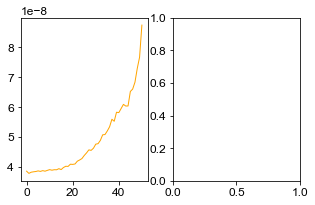

In [42]:
fig4, ax4 = plot.subplots(nrows=1, ncols=2, figsize=(5, 3))


if 1:
   # ax[0].plot(iteration_angle_10,contact_angle_list_top_10, color = color_list[0], linewidth = size_line)
    ax4[0].plot(iteration_list,volume_list , color = 'orange', linewidth = 1, label = 'ref. = 3', markersize = 1)
